## DeepWideNet Architecture

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, concatenate
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Add, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.activations import selu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def wide_block(x, filters, name):
    f1, f2, f3 = filters
    prev_layer = x

    # wide shortcut
    conv_1x1_shortcut = Conv2D(filters=f1, kernel_size=(1, 1), activation=selu, padding='same')(prev_layer)
    conv_1x1_shortcut = BatchNormalization(axis=3)(conv_1x1_shortcut)

    # sub-deep path
    conv_5x5 = Conv2D(filters=f2, kernel_size=(5, 5), strides=(1, 1), activation=selu, padding='same')(prev_layer)
    conv_5x5 = BatchNormalization(axis=3)(conv_5x5)
    conv_3x3 = Conv2D(filters=f3, kernel_size=(3, 3), strides=(1, 1), activation=selu, padding='same')(conv_5x5)
    conv_3x3 = BatchNormalization(axis=3)(conv_3x3)

    # concatenation block 1
    sub_deep_block = concatenate([prev_layer, conv_3x3], axis=3)
    sub_deep_block = BatchNormalization(axis=3)(sub_deep_block)

    # concatenation block 2
    final_concat = concatenate([conv_1x1_shortcut, sub_deep_block], axis=3, name=name)

    return final_concat

In [18]:
input_layer = Input(shape=(72,72,3))

x = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), activation=selu)(input_layer)
x = BatchNormalization()(x)

# conv_3x3
x = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), activation=selu)(x)
x = BatchNormalization()(x)

x = wide_block(x,[128,16,32],'dw_1a')
x = wide_block(x,[128,16,32],'dw_1b')
x = wide_block(x,[128,16,32],'dw_1c')

x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = BatchNormalization()(x)

x = wide_block(x,[256,32,64],'dw_2a')
x = wide_block(x,[256,32,64],'dw_2b')
x = wide_block(x,[256,32,64],'dw_2c')

x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = BatchNormalization()(x)

x = wide_block(x,[512,64,128],'dw_3a')
x = wide_block(x,[512,64,128],'dw_3b')
x = wide_block(x,[512,64,128],'dw_3c')
#
x = MaxPooling2D(pool_size=(7,7), strides=(2,2))(x)
x = BatchNormalization()(x)

# classification
x = Flatten()(x)
x = Dense(units=512, activation=selu)(x)
x = Dropout(0.5)(x)
exp_output = Dense(units=42, activation=softmax)(x)

exp_conv = Model(input_layer,exp_output)
exp_conv.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 conv2d_329 (Conv2D)            (None, 34, 34, 64)   4864        ['input_16[0][0]']               
                                                                                                  
 batch_normalization_460 (Batch  (None, 34, 34, 64)  256         ['conv2d_329[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_330 (Conv2D)            (None, 32, 32, 192)  110784      ['batch_normalization_460[0

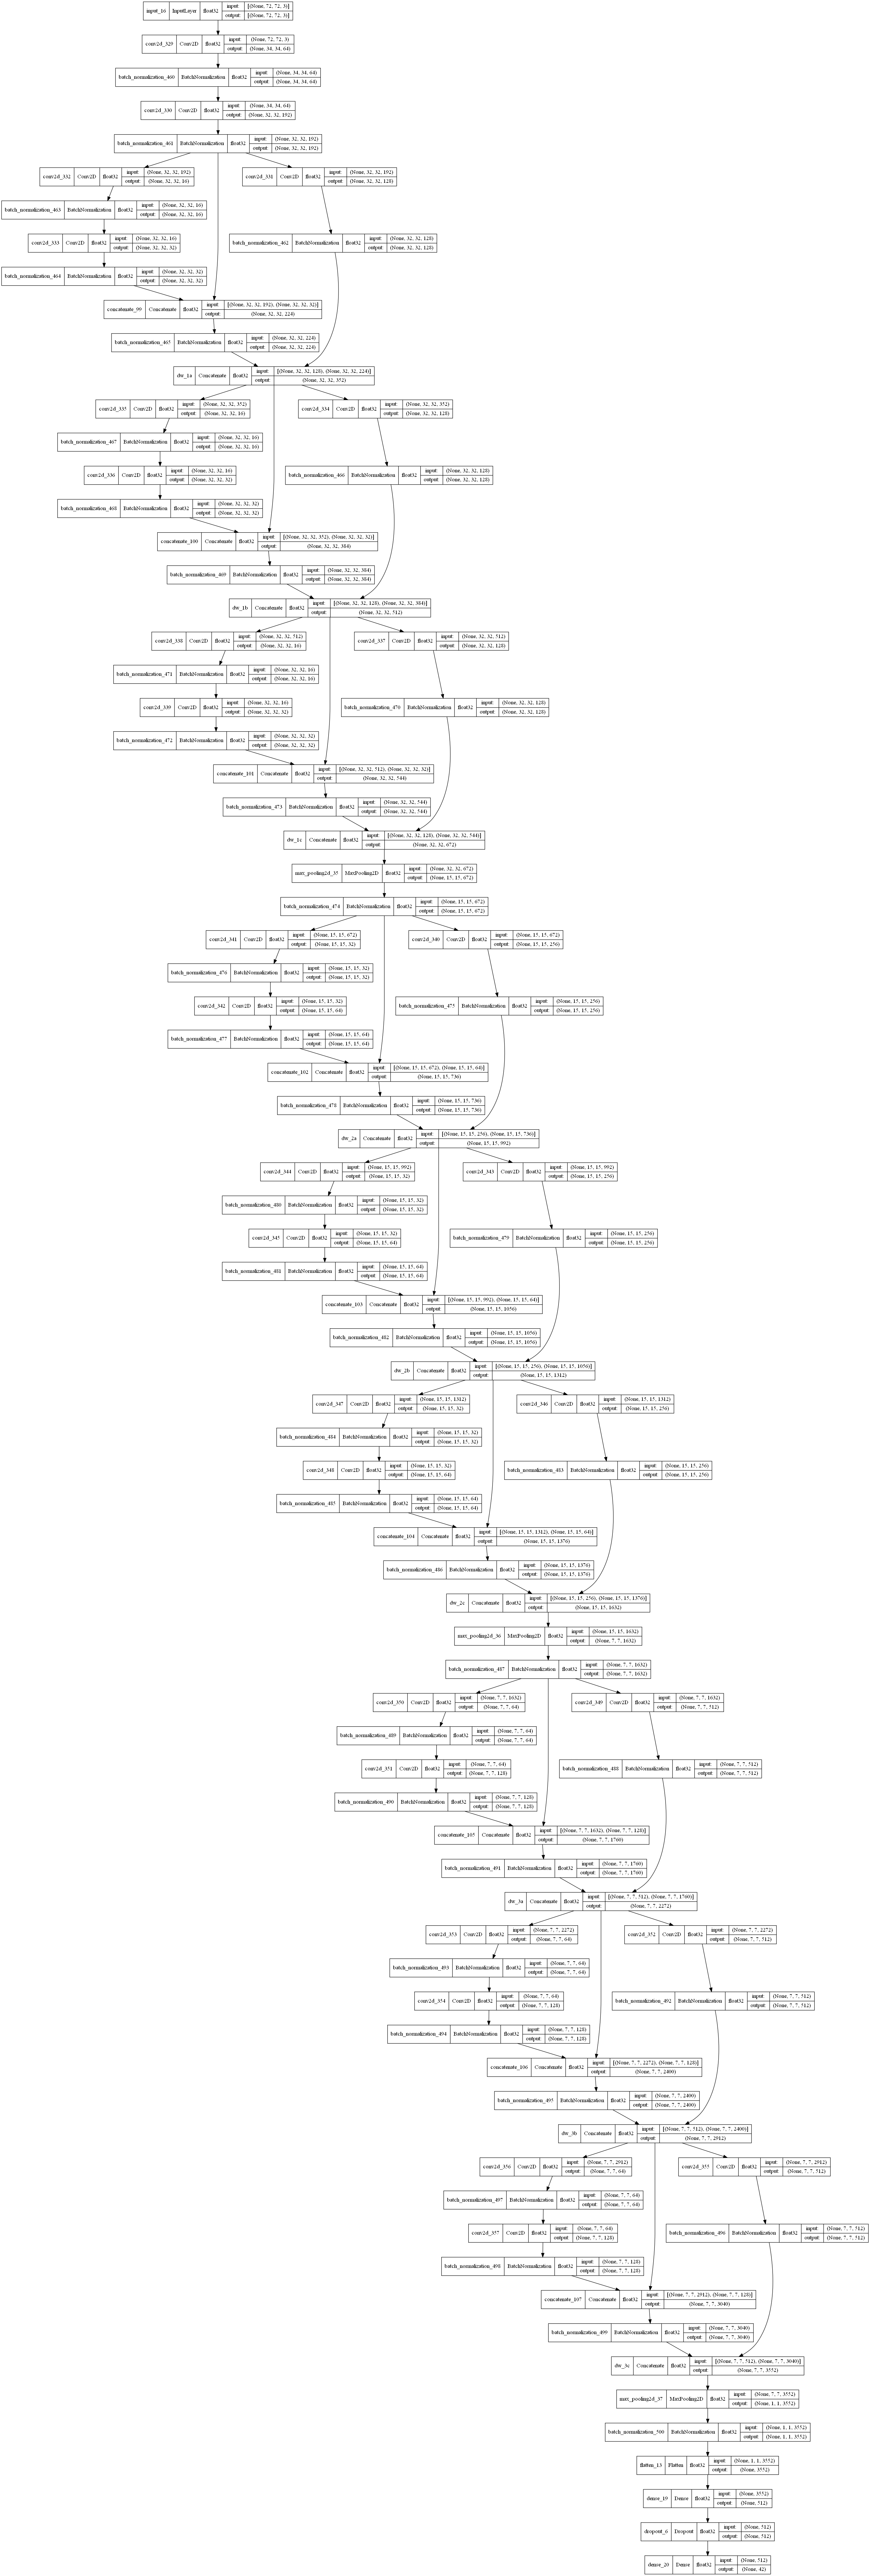

In [19]:
plot_model(model=exp_conv,
           to_file='DeepWideNet.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [13]:
model = load_model('../../best models/wb_1_best_checkpoint_only.hdf5')
isplant = load_model('../../best models/plant_or_not_vgg_transfer.hdf5')

In [11]:
model.layers

In [14]:
isplant.layers

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 34, 34, 64)   4864        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 34, 34, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 192)  110784      ['batch_normalization[0][0]']

In [15]:
isplant.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [16]:
is_plant_generator = ImageDataGenerator(rescale=1/255,
                                        validation_split=0.3)

isplant_gen = is_plant_generator.flow_from_directory('../../../data/plant',
                                                     batch_size=128)

Found 52755 images belonging to 2 classes.
